# Intro to basics of filtering theory/application (and how to write functions!)
* low-pass and high filter design and implementation - build an intuition for how they work
* more advanced stuff about actual implementation (not covered in class):
    * infinite fall-off in time domain
    * windowing (Blackman)
    * temporal shifting/distortions
    
**IMPORTANT - if you are actually going to design and implement your own filters, make sure you read all of the material in this notebook, esp the "advanced" section** 

jserences@ucsd.edu, 10252021

## Topic and basic principle of filtering
* A low-pass filter will "pass" (or keep) low frequency components of a signal and attenuate high frequency components
* A high-pass will do the opposite - it will pass high frequencies and attenuate low frequency components
* Implementation
    * Build a filter in the time or frequency domain
        * if built in time domain, then FFT it to get a frequency domain representation
        * then FFT the time domain signal that you want to filter (and retain complex values - not just the amplitude)
        * then multiply the FFT'd filter by the FFT'd timeseries
        * then iFFT the filtered signal back into the time domain

https://pubmed.ncbi.nlm.nih.gov/27375930/

![ca+ imaging](ca_imaging.jpg)



![econ data](cycles_econ.png)

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# also define the default font we'll use for figures. 
plt.rc = {'fontname':'Arial', 
          'size':'20'}

## Make a function to do FFT to save time typing later
* If you ever start typing out the same code over and over again, then probably a good idea to just write it once in the form of a function so that you can re-use it
* In this case, our function needs to be able to handle general inputs (e.g., a timeseries and a dt) and then return the amp and frequency axis after doing the FFT
* Note that variables defined outside of a function are in the "global namespace" - this means that they can be accessed from anywhere in the notebook
* In contrast, variables that are declared (or defined) inside of function are in the "local namespace" of that function and they disapear as soon as the function exits


In [2]:
def do_fft(sig, dt):
    
    # rfft = fft for real valued inputs
    cplx = np.fft.rfft(sig)   

    # amplitude
    amp_filt = np.abs(cplx)  

    # normalize amp by the number of data points, 
    amp_filt = (amp_filt  / len(sig) ) * 2   

    # figure out the frequency resolution of the data 
    freq_x = np.fft.rfftfreq(len(sig), dt)          
    
    # return the variables of interest so 
    # the values can be used outside of this function
    return amp_filt, cplx, freq_x

## Low pass filter
* Ideal low pass filter will only let through frequencies you want to keep and will truncate high frequencies
* The ideal filter will look like a step function in the frequency domain
* Take the following steps to illustrate
    * Generate a signal that we can use for simulations
    * Make a step function filter in the frequency domain and see what happens...

In [3]:
# define a set of frequencies for our simulated signal. 
# lets not add any IID noise yet so that the results turn out the same each time
Lf = 1  # lowest frequency
Hf = 16 # highest frequency

#generate list
frequs = np.linspace(Lf, Hf, (Hf-Lf)+1)
print(frequs)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]


In [4]:
# make a simulated signal
np.random.seed(0)
sr = 512                        # samp rate in Hz
tmax = 4                        # duration of signal, in s
dt = 1/sr                       # time step, reciprocal of the sr
t = np.arange(0,tmax,dt)        # time axis

# add up a bunch of sin waves at each of our desired frequencies
sig = np.zeros(len(t))
for f in np.arange(len(frequs)):
    sig += np.random.rand() * np.sin(2*np.pi*frequs[f]*t)

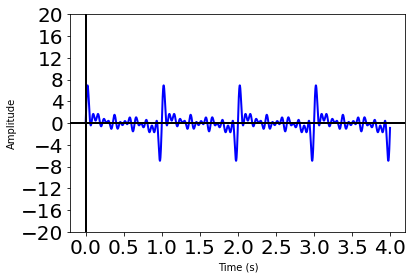

In [5]:
# Plot
plt.plot(t, sig, 'b-', linewidth = 2)    # specify x,y data...in this case time and amplitude of sin

# put some labels on the axes
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# set the tick marks
plt.xticks(np.arange(0,tmax+.5,.5), color='k', size=20)
plt.yticks(np.linspace(-20,20,11), color='k', size=20)

# add some nice vertical/horizontal lines 
plt.axvline(0, color = 'k', linewidth = 2)
plt.axhline(0, color = 'k', linewidth = 2)

# show it
plt.show()

## Now FFT and lets have a look at the frequency spectrum 

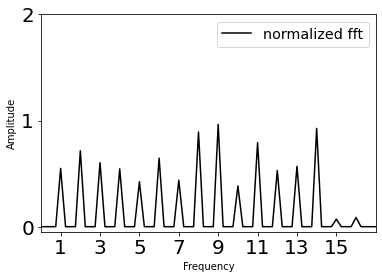

In [6]:
# call our function to do the FFT
amp, cplx, freq_x = do_fft(sig, dt)

# plot the fft
plt.plot(freq_x, amp, 'k')            # plot amplitude 

plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.xticks(frequs[::2], color='k', size=20)
plt.yticks((0,1,2), color='k', size=20)

# set the axis limits
plt.xlim([0, Hf+1])

# put a legend on it...
plt.legend(['normalized fft'], loc='best', fontsize='x-large')  

# show it
plt.show()

## Now design an ideal low pass filter - one that only passes frequencies below the cutoff and truncates everything else.
* Note that this will look like a box-car function in the frequency domain
* If you multiply this filter with the FFT of the original data, and then iFFT, you should only have low frequencies left!
* This kind of filter with a hard cutoff is often referred to as a **brick-wall filter**

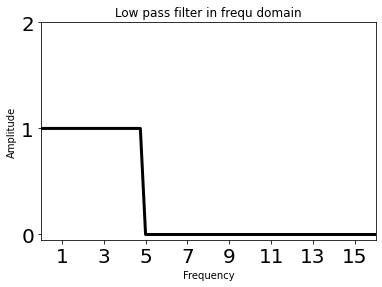

In [7]:
# lets pass everything below 5Hz and cut off everything else
lowpass_cut = 5

# find the freq in our FFT range that is closest to our desired cutoff point
cutoff_pnt = np.argmin(np.abs(freq_x-lowpass_cut)) # more general way to do it...

# make the filter
lp_filt = np.zeros(len(freq_x))
lp_filt[0:cutoff_pnt] = 1

plt.plot(freq_x, lp_filt, c='k', linewidth=3)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.xticks(frequs[::2], color='k', size=20)
plt.yticks((0,1,2), color='k', size=20)

# set the axis limits
plt.xlim([0, Hf])

plt.title('Low pass filter in frequ domain')
plt.show()

## Apply the filtering by multiplying it with the data 
* Notice that the frequency domain representation of our brick wall filter is 1's for the frequencies we want to keep, and 0 otherwise...
* So to filter data, you can multiply the fft of your signal with the frequency domain representation of the filter...
* then ifft to take the filtered signal back into the time domain

In [8]:
# do the mutliplication in the frequ domain
# NEED THE COMPLEX VALUED SIGNAL, not just the amplitude
# so use sp, not amp

# filter the data (multiply, iFFT)
# do it in steps here to make it clear
multiply_in_frequ_domain = cplx * lp_filt

# take the ifft
filtered_sig = np.fft.irfft(multiply_in_frequ_domain)

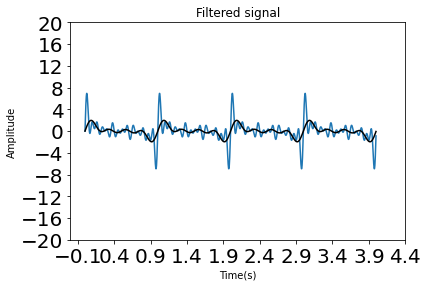

In [9]:
# plot the filtered data...all the high frequency stuff > 5Hz should be gone!
plt.plot(t, sig)  # orig sig
plt.plot(t, filtered_sig, 'k')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.xticks(np.arange(-.1,tmax+.5,.5), color='k', size=20)
plt.yticks(np.linspace(-20,20,11), color='k', size=20)
plt.title('Filtered signal')
plt.show()

## Now FFT our filtered signal to see what it looks like in the frequ domain

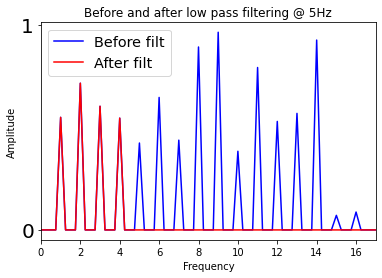

In [10]:
# FFT the filtered signal...
amp_filt, cplx, freq_x = do_fft(filtered_sig, dt)

# plot the fft
plt.plot(freq_x, amp, 'b')            # plot amplitude of the original signal
plt.plot(freq_x, amp_filt, 'r')       # plot amplitude of filtered signal 

# put a legend on it...
plt.legend(['Before filt', 'After filt'], loc='best', fontsize='x-large')  
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
# plt.xticks(frequs[::2], color='k', size=20)
plt.yticks((0,1), color='k', size=20)

# set the axis limits
plt.xlim([0, Hf+1])

plt.title('Before and after low pass filtering @ 5Hz')

# show it
plt.show()

## We can use a similar process that we discussed in our low pass filter tutorial to create a high-pass filter
* A high-pass filter looks like our brick wall low pass filter (see first part of last tutorial), except that it is zeros for low-frequencies and non-zero for high-frequencies

### Make our filter - just like with the low pass filter, but invert the filter
* Since we're using this a lot, lets make a function out of it...
* note the 'writefile' cell magic - that will write out a .py file (really just a text file) that we can then load and use later...
* include relevant info in the "docstring" section for helpful usage hints...

In [11]:
%%writefile my_brick_filt.py

# include the import before the functions so that when we call this module later we load numpy once. 
import numpy as np

def define_filt(fx, filt_freq, type_filt):

    """Define a simple lp or a hp brick wall filter - don't use this in practice, just for tutorial

    Args:
        fx (array): list of frequencies, taken from np.fft.rfftfreq
        filt_freq (float): cutoff frequency
        type_filt (str): low pass or high pass filter, options 'lp', 'hp'

    Returns:
        brick: brick wall filter in frequency domain

    """
    # find the freq in our FFT range that is closest to our desired cutoff point
    cutoff_pnt = np.argmin(np.abs(fx-filt_freq)) # more general way to do it...

    # check filter type...if lp then do nothing, else if hp invert, else return msg

    # init filter with all 0's
    brick = np.zeros(len(fx))

    if type_filt == 'lp':
        # make the filter
        brick[0:cutoff_pnt] = 1
    
    elif type_filt == 'hp':
        # make the filter
        brick[cutoff_pnt:] = 1
    
    else:    
        print('error - specify lp or hp filter')
        return 0
    
    return brick

# Another function to apply the filter. this second function will be in the same module      
def apply_filt(input_sig, input_filter):
    """Apply a filter to an input timeseries (using freq domain multiplication)

    Args:
        input_sig (float): timeseries to be filtered (in time domain)
        input_filter (float): filter to apply to input_sig (in frequency domain)

    Returns:
        filt_sig (float array): filtered signal in time domain

    """
    
    # fft our time domain signal
    fft_sig = np.fft.rfft(input_sig)

    # multiply in freq domain, then ifft to go back into the time domain
    return np.fft.irfft(fft_sig*input_filter)


# Another function to apply the filter. this second function will be in the same module      
def apply_filt_2D(input_sig, input_filter):
    """Apply a filter to an input timeseries (using freq domain multiplication)

    Args:
        input_sig (float): timeseries to be filtered (in time domain). To keep it simple for our sample
        data set, time will run over rows in the data so we will fft with axis=1
        
        input_filter (float): filter to apply to input_sig (in frequency domain)

    Returns:
        filt_sig (float array): filtered signal in time domain

    """
    r,c = input_sig.shape
    
    # fft our time domain signal
    fft_sig = np.fft.rfft(input_sig, axis = 1)
    
    # make our filter the same size as the data. 
    filt_2d = np.tile(input_filter,(r,1))
    
    # multiply in freq domain, then ifft to go back into the time domain
    return np.fft.irfft(fft_sig*filt_2d)

Overwriting my_brick_filt.py


### Load our 'module' with the two functions that we wrote...
* get 'help' with the ?

In [12]:
# import our filter object
import my_brick_filt as mbf

# do this so that if you modify your .py file it will automatically reload
%load_ext autoreload
%autoreload 2
# note: 2== Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.

In [13]:
mbf.define_filt?

### Then define a high pass filter...

In [14]:
# use our signal (sig) and freq_x from earlier in the tutoral
hp = 12   # pass high frequencies above 10hz
hp_filt = mbf.define_filt(fx=freq_x, filt_freq=hp, type_filt='hp')

lp = 5   # pass high frequencies above 10hz
lp_filt = mbf.define_filt(fx=freq_x, filt_freq=hp, type_filt='lp')

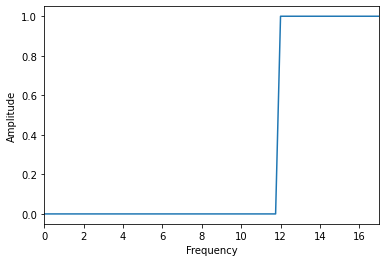

In [15]:
# have a look at the hp filter...
plt.plot(freq_x, hp_filt)

plt.xlabel('Frequency')
plt.ylabel('Amplitude')
# plt.xticks(frequs[1::2], color='k', size=20)
# plt.yticks((0,1,2), color='k', size=20)

# set the axis limits
plt.xlim([0, Hf+1])
plt.show()

### Now apply it using our function!
* also introduce passing input params by keyword
* a little more typing, but more robust to argument order errors

In [16]:
filt_sig = mbf.apply_filt(input_sig=sig, input_filter=hp_filt)

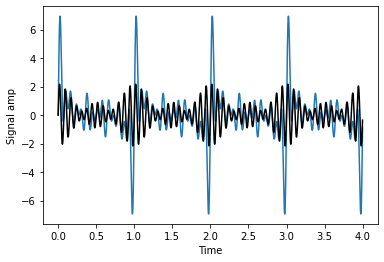

In [17]:
# have a look at the hp filtered data...
plt.plot(t, sig)
plt.plot(t, filt_sig, 'k')

plt.xlabel('Time')
plt.ylabel('Signal amp')

plt.show()

### fft our filtered time domain signal and plot...

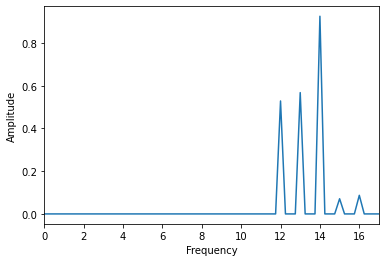

In [18]:
# do fft...
amp, cplx, freq_x = do_fft(filt_sig, dt)

plt.plot(freq_x, amp)

plt.xlabel('Frequency')
plt.ylabel('Amplitude')
# plt.xticks(frequs[1::2], color='k', size=20)
# plt.yticks((0,1,2), color='k', size=20)

# set the axis limits
plt.xlim([0, Hf+1])

plt.show()

# More advanced concepts...roll-off, filters that go on forever in the time domain, time/freq resolution tradeoff, and how to deal with this... 

## What does that filter look like in the time domain?
* Inverse FFT the low-pass filter
* Its a sinc (cardinal sin) function

<div class="alert alert-info">
Notice that that the time-domain representation goes on forever in both directions...its high resolution in the frequency domain forces a low res time domain response. This is a problem for implementing with finite length data sets! We'll see how to address this below. 
</div>

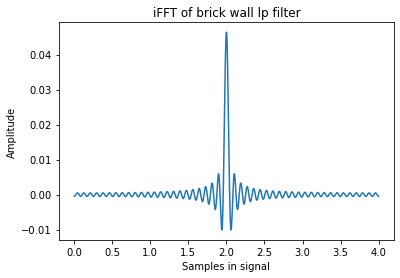

In [19]:
# iFFT
inv_filter = np.fft.irfft(lp_filt)

# symetric over the span, so center to better visualize
inv_filter = np.roll(inv_filter, int(len(inv_filter)/2))
plt.plot(t, inv_filter)
plt.xlabel('Samples in signal')
plt.ylabel('Amplitude')
plt.title('iFFT of brick wall lp filter')
plt.show()

### Make another simulated signal with some higher frequencies in it (makes for a better example and can play with filtering higher frequs). 

In [20]:
sr = 512                        # samp rate in Hz
tmax = 4                        # duration of signal, in s
dt = 1/sr                       # time step, reciprocal of the sr
t = np.arange(0,tmax,dt)        # time axis

#generate list
frequs = [3,20,60]

# add up a bunch of sin waves at each of our desired frequencies
sig = np.zeros(len(t))
for f in np.arange(len(frequs)):
    sig += np.sin(2*np.pi*frequs[f]*t)
    

## Now take a look at how to design this kind of filter in a more principled manner and deal with the infinite fall-off of the sinc for finite length data sets
* The iFFT of an ideal lp filter is a sinc function
* Can build the function in the time domain, then fft the filter and the signal, the multiply, then iFFT to get our filtered signal

In [21]:
# First specify a cutoff frequency, fc, that is a fraction of the sampling rate over 0, .5...why is the max .5?
# hint: remember from last week how the sr limited the frequency range you can estimate using a FFT...
fc = 0.1 

# and fc*sr == cutoff freq

# Then specify the transition band, again this will be a fraction of the sampling rate over 0, .5
# smaller numbers here will more closely mimic a brick wall (good frequ res, poor temporal res)
b = 0.05  

# more on this below, but now need to make sure that ceil(4/b) is odd
N = int(np.ceil((4 / b)))

# figure this out by returning the remainder (modulo operator) after dividing by 2
# if its even, then this == 0, else non-zero, so if its not true (i.e. == 0), then we add 1!
# if you don't do this then the function won't be centered
# An odd-length symmetrical filter will have delay that is an integer number of samples
# more on this in a bit...
if not N % 2: N += 1  
    
# generate span over which to eval sinc function    
n = np.arange(N)

# Compute the filter, taking into account our cutoff freq
sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
 
# Normalize to have an area of 1 (unit area)
sinc_func = sinc_func / np.sum(sinc_func)

## Plot the sinc function

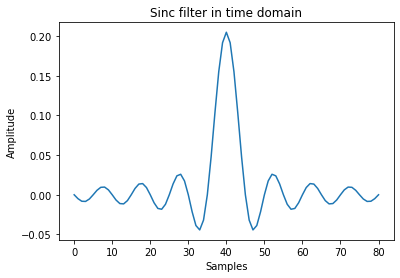

In [22]:
plt.plot(n, sinc_func)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Sinc filter in time domain')
plt.show()

## Now lets look at the frequency domain representation of this filter
* Remember that a sinc function goes on forever in both directions, and we've only evaluated it over a small range

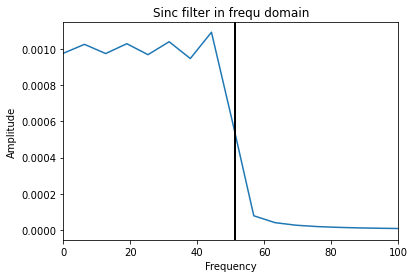

In [23]:
# take the fft, convert to amplitude, then normalize
sinc_fft = (np.abs(np.fft.rfft(sinc_func)) / len(filtered_sig) ) * 2

# figure out the frequency resolution of the data
# recall that our 'dt' here is calculated based on the signal 
# that we set up at the begining of the tutorial with a 
# sr = 512, so fc*512 should be around our filter fall-off
freq = np.fft.rfftfreq(sinc_func.size, dt)   

plt.plot(freq, sinc_fft)
plt.axvline(fc*sr, color = 'k', linewidth = 2)
plt.xlim([0,100])
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Sinc filter in frequ domain')
plt.show()

### Note that it looks sort of like our brick wall filter, but the fall-off is not quite so sharp and there are weird bumps in it (esp in the low frequ part of the band)
* Our 'b' param will control the sharpness of the fall-off
* The bumps are the by-product of truncating a filter function that goes in both directions forever...
* Solution for the bumps is to apply a window that dampens the edge artifacts
    * A common choice - from among many - is a Blackman window 

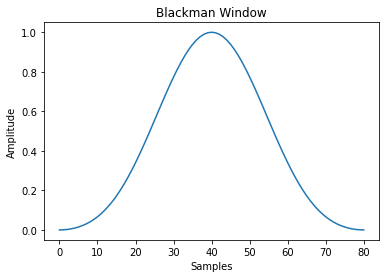

In [24]:
# build a Blackman window (by hand at first), take a look, and then apply to the filter and recompute everything
b_window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + \
    0.08 * np.cos(4 * np.pi * n / (N - 1))

# or, the boring way
# b_window = np.blackman(N)

plt.plot(n, b_window)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Blackman Window')
plt.show()

#### Apply the window to the sinc filter...
* Should dampend the edges while leaving the center of the filter unchanged

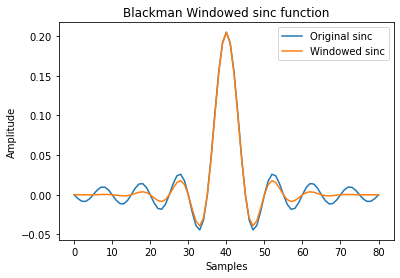

In [25]:
# element-wise multiplication
win_sinc_func = sinc_func * b_window
plt.plot(n, sinc_func)
plt.plot(n, win_sinc_func)
plt.legend(['Original sinc', 'Windowed sinc'])
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Blackman Windowed sinc function')
plt.show()

### Now lets have a look at the frequency domain representation of the windowed sinc function
* Should yeild a nice smooth function in the frequency domain!

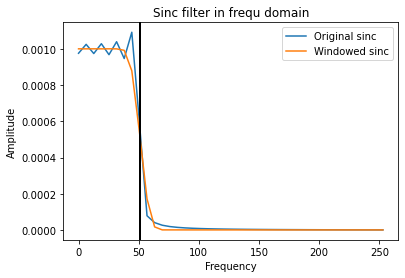

In [26]:
# take the fft, convert to amplitude, then normalize
win_sinc_fft = (np.abs(np.fft.rfft(win_sinc_func)) / len(filtered_sig) ) * 2

# figure out the frequency resolution of the data
# recall that our 'dt' here is calculated based on the signal 
# that we set up at the begining of the tutorial with a 
# sr = 512, so fc*512 should be around our filter fall-off
freq = np.fft.rfftfreq(win_sinc_func.size, dt)   

# plot
plt.plot(freq, sinc_fft)
plt.plot(freq, win_sinc_fft)
plt.legend(['Original sinc', 'Windowed sinc'])
plt.axvline(fc*sr, color = 'k', linewidth = 2)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Sinc filter in frequ domain')
plt.show()

## Now let's apply the windowed sinc function to the data to see how well it works.

In [27]:
# fft our signal
fft_sig = np.fft.rfft(sig)

# need to zero pad to make the filter the same length as the signal
X = len(sig)
Y = len(win_sinc_func)

# zero pad in the time domain
if Y<X:
    win_sinc_func = np.hstack((win_sinc_func, np.zeros(X-Y)))

# fft the filter
fft_filt = np.fft.rfft(win_sinc_func)

# multiply in freq domain, then ifft to go back into the time domain
filt_sig = np.fft.irfft(fft_sig*fft_filt)

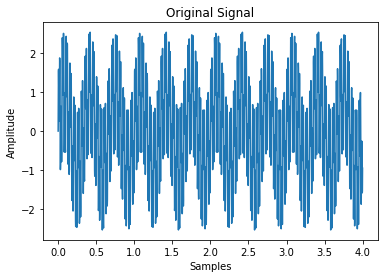

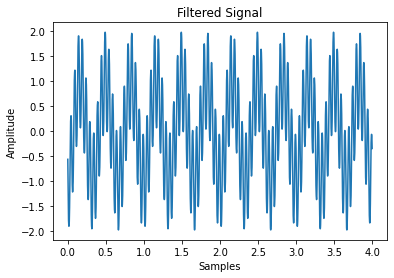

In [28]:
# Plot the regular signal
plt.plot(t, sig)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Original Signal')
plt.show()

# plot the filtered signal
plt.plot(t, filt_sig)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Filtered Signal')
plt.show()

## See how well we did - our filter should have cut off > 50Hz and retained frequencies lower than the cutoff and left them relatively unchanged
* Notice that power at the 50Hz component of our signal is heavily attenuated!
* Go back and repeat with b = .01 - that will make the roll-off much sharper in the frequ domain (i.e. closer to a brick wall filter we started off with)

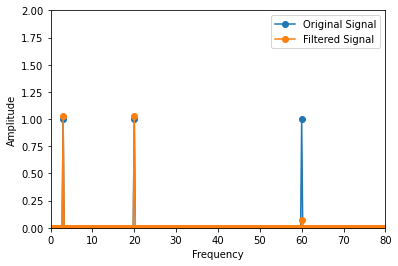

In [29]:
# fft our signal
fft_sig = (np.abs(np.fft.rfft(sig)) / len(sig) ) * 2
freq = np.fft.rfftfreq(sig.size, dt)   

# fft our filtered signal
fft_filt_sig = (np.abs(np.fft.rfft(filt_sig)) / len(filt_sig) ) * 2

# plot
plt.plot(freq, fft_sig, marker='o')
plt.plot(freq, fft_filt_sig, marker='o')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.xlim([0, 80])
plt.ylim([0, 2])
plt.legend(['Original Signal', 'Filtered Signal'])
plt.show()

## So the filtering part works...however, if you plot the filtered signal on top of the original signal, you'll notice that there is a temporal shift that depends on the filter roll-off (b)
* The length of the filter is N, then we can correct for this by shifting by (N-1)/2

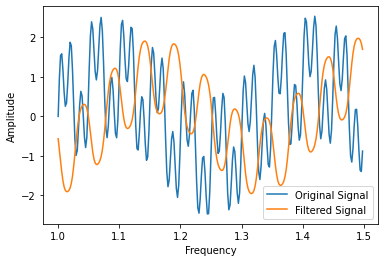

In [30]:
# to see this most clearly, lets just zoom in and plot a small segment of the data
# can do boolean indexing, but demo the "where" function here (like Matlab "find")
index = np.where((t>=1) & (t<1.5))

# plot
plt.plot(t[index], sig[index])
plt.plot(t[index], filt_sig[index])
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.legend(['Original Signal', 'Filtered Signal'])
plt.show()

### Can account for that shift pretty easily
* Remember that we made our filter length odd (N in the filter definition, which in turn is related to b, or the roll off)
* We can then shift the filtered data by (N-1)/2 timepoints, or 1/2 of the filter width, to correct for offset

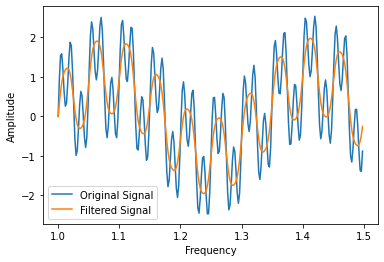

In [31]:
index = np.where((t>=1) & (t<1.5))
# shift by (N-1)/2 - this will be an integer so long as N is odd
# which is a condition that we enforced earlier when designing the 
# filter...shift by corresponding timepoints
shift_by = dt*((N-1)/2)  # convert to units of filter length in time: so number of points * dt
shift_index = np.where((t>=1+shift_by) & (t<1.5+shift_by))

# plot - should be all lined up!
plt.plot(t[index], sig[index])
plt.plot(t[index], filt_sig[shift_index])
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.legend(['Original Signal', 'Filtered Signal'])
plt.show()

## Why not have a sharp roll-off all the time, esp given that you can shift your data around in time to account for the offset?
* Sharper roll off filters lead to larger shift in the time domain of the output signal
* This is due to the inherent trade-off between time-domain and frequency domain resolution (so sharper freq domain filter, or steeper roll off, will require a longer window in the time domain).
* For finite length signals this can be a problem (e.g. if you only have 0.5 sec of signal that you're filtering...)